In [1]:
import numpy as np
import pandas as pd

import base_dados_2

import os

import gensim
from gensim import corpora
from gensim.models import ldamodel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.wrappers import LdaMallet


import spacy

import itertools
from itertools import islice
import random
import pyLDAvis
import pyLDAvis.gensim
from IPython.display import Image

import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import re

from pprint import pprint

import matplotlib.pyplot as plt
%matplotlib inline

#pwd
#ls

import logging 

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=None)
rootLogger = logging.getLogger()
rootLogger.setLevel(logging.INFO)
rootLogger.propagate = False

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\Felipe\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Users\Felipe\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""


In [97]:
df19=base_dados_2.base_sessoes('2019')

In [8]:
#df19=base_dados_2.base_sessoes('2019')

In [98]:
df19.to_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\LDA\df_2019.csv',sep=';',index=False)

In [105]:
df_.to_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\LDA\df_2019_menor.csv',sep=';',index=False)

In [5]:
#df_=pd.read_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\LDA\df_2015_menor.csv',sep=';')

In [100]:
df19[df19['Fase']!='ABERTURA DA SESSÃO']['Fase'].unique()

array(['LEITURA DA ATA', 'EXPEDIENTE', 'PEQUENO EXPEDIENTE',
       'ORDEM DO DIA', 'GRANDE EXPEDIENTE', 'ENCERRAMENTO',
       'BREVES COMUNICAÇÕES', 'COMUNICAÇÕES PARLAMENTARES', ''],
      dtype=object)

In [101]:
df_=df19[df19['Fase']!='ABERTURA DA SESSÃO']

In [102]:
df_=df_[df_['Fase']!='EXPEDIENTE']

In [103]:
df_=df_[df_['Fase']!='LEITURA DA ATA']

In [104]:
df_=df_[df_['Presidente']=='DEPUTADO'].reset_index(drop=True)


In [106]:
dados=df_.Discurso.values.tolist()

In [190]:
dados2=[]
for i in dados:
    if len(i)>100:
        dados2.append(i)

In [192]:
# Remove new line characters
dados2 = [re.sub('\s+', ' ', sent) for sent in dados2]

# Remove distracting single quotes
#data = [re.sub("\'", "", sent) for sent in data]

In [110]:
def discurso_para_palavras(discursos):
    
    for fala in discursos:
        yield(gensim.utils.simple_preprocess(str(fala),deacc=True))

In [193]:
dados_p=list(discurso_para_palavras(dados2))

In [194]:
bigram=gensim.models.Phrases(dados_p,min_count=20,threshold=50)
trigram=gensim.models.Phrases(bigram[dados_p],threshold=50)

C:\Users\Felipe\Anaconda3\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [195]:
bigram_mod=gensim.models.phrases.Phraser(bigram)
trigram_mod=gensim.models.phrases.Phraser(trigram)

In [196]:
          
StopWords=set(stopwords.words('portuguese'))

add_stopwords=['tambem','registrar','discursar','gostar','agradeco','seguir','presidente','sr','partir','tempo','orientar',\
               'destacar','nome','srs','deputados','lider','minoria','iniciar','estar','sao','sessao','encerrar','julho',\
               'falar','nao','fazer','aqui','querer','dizer','ja','dar','agora','sim','destaque','art','hoje','estar',\
               'falar','dizer','voces','sra','exa','ainda','dizer','contar','saber','ficar','deixar','passar','deliberativa',\
               'estao','ser','nº','cd','extraordinaria','partir']

for word in add_stopwords:
    StopWords.add(word)
            

In [197]:
def remove_stopwords(texto):
    return [[palavra for palavra in simple_preprocess(str(doc)) if palavra not in StopWords] for doc in texto]

def make_bigrams(texto):
    return [bigram_mod[doc] for doc in texto]

def make_trigrams(texto):
    return [trigram_mod[bigram_mod[doc]] for doc in texto]

def lemmatization(texto,tags=['NOUN','ADJ','VERB','ADV']):
    texto_out=[]
    for sent in texto:
        doc=nlp(' '.join(sent))
        texto_out.append([token.lemma_ for token in doc if token.pos_ in tags])
    return texto_out

In [198]:
dados_p_nosw=remove_stopwords(dados_p)

In [199]:
dados_p_bigrams=make_bigrams(dados_p_nosw)
dados_p_trigrams=make_trigrams(dados_p_nosw)

In [200]:
nlp=spacy.load('pt_core_news_sm',disable=['parser','ner'])

In [201]:
dados_p_lem=lemmatization(dados_p_bigrams,tags=['NOUN','ADJ','VERB','ADV'])

In [202]:
dados_p_lem_nosw=remove_stopwords(dados_p_lem)

In [203]:
dados_dict=corpora.Dictionary(dados_p_lem_nosw)

In [204]:
dados_dict.filter_extremes(no_below=20, no_above=0.3)

In [205]:
textos=dados_p_lem_nosw

In [206]:
corpus=[dados_dict.doc2bow(text) for text in textos]


In [212]:
logging.disable(logging.CRITICAL)
lda_model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dados_dict,num_topics=10,random_state=100,update_every=1,\
                                         chunksize=100,passes=10,alpha='auto',per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda=lda_model[corpus]

[(0,
  '0.021*"lei" + 0.018*"formar" + 0.016*"tratar" + 0.016*"animar" + '
  '0.014*"comissao" + 0.014*"projeto" + 0.014*"policiar" + 0.013*"garantir" + '
  '0.012*"cultura" + 0.012*"federal"'),
 (1,
  '0.047*"educacao" + 0.039*"professorar" + 0.029*"texto" + 0.025*"lutar" + '
  '0.020*"publicar" + 0.018*"ministrar" + 0.016*"pai" + 0.015*"brasileiro" + '
  '0.012*"pecar" + 0.012*"defeso"'),
 (2,
  '0.022*"parlamentar" + 0.016*"pai" + 0.015*"ver" + 0.014*"vir" + '
  '0.013*"defender" + 0.011*"politicar" + 0.010*"dia" + 0.009*"respeitar" + '
  '0.009*"pessoa" + 0.009*"povo_brasileiro"'),
 (3,
  '0.032*"pessoa" + 0.031*"vidar" + 0.027*"saude" + 0.015*"nordeste" + '
  '0.014*"cuidar" + 0.011*"recurso" + 0.010*"valer" + 0.010*"familias" + '
  '0.010*"situacao" + 0.010*"precisar"'),
 (4,
  '0.104*"reformar" + 0.086*"previdencia" + 0.031*"trabalhador" + '
  '0.028*"aposentadoria" + 0.023*"proposto" + 0.023*"aposentar" + '
  '0.023*"ganhar" + 0.022*"pobre" + 0.020*"direito" + 0.013*"viuvar"'),

In [213]:
coherence_model_lda=CoherenceModel(model=lda_model,texts=dados_p_lem_nosw,dictionary=dados_dict,coherence='c_v')
coherence_lda=coherence_model_lda.get_coherence()
print('\nCoherence Score: ',coherence_lda)


Coherence Score:  0.39670983365979756


In [131]:
def compute_coherence_values(dic,corpus,texts,limit,start=2,step=3):
    
    coherence_values=[]
    model_list=[]
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=dic,num_topics=num_topics,random_state=100,update_every=1,\
                                         chunksize=100,passes=5,alpha='auto',per_word_topics=True)
        model_list.append(model)
        coherencemodel=CoherenceModel(model=model, texts=texts, dictionary=dic, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        coherence_lda=(num_topics,coherencemodel.get_coherence())
        
        print('\nCoherence Score: ',coherence_lda)
        
        
    return model_list, coherence_values,coherence_lda

In [214]:
#logging.disable(logging.CRITICAL)
#model_list,coherence_values,coh_lda2=compute_coherence_values(dados_dict,corpus,dados_p_lem_nosw,20,start=2,step=2)

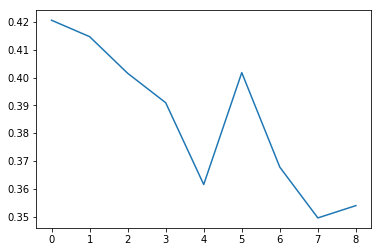

In [138]:
plt.plot(coherence_values2)

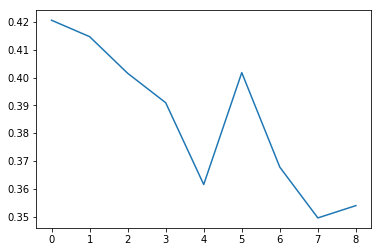

In [143]:
plt.plot(coherence_values)

In [422]:
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, dados_dict)
#vis

In [421]:

pyLDAvis.save_html(vis,r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\LDA\lda.html')

In [262]:
def format_topics_sentences(texts,ldamodel=lda_model, corpus=corpus):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        ranking = sorted(row[0], key=lambda x: x[1], reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(ranking):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [417]:
df_topic_sents_keywords = format_topics_sentences(dados2,ldamodel=lda_model, corpus=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3563,"educacao, professorar, texto, lutar, publicar,...","- Sr. Presidente, eu queria deixar registrada ..."
1,1,6.0,0.1676,"real, milhoes, bilhoes, dinheiro, pagar, rende...",- Sr. Presidente Luciano Bivar — Pernambuco no...
2,2,3.0,0.3045,"pessoa, vidar, saude, nordeste, cuidar, recurs...","- Sr. Presidente, Sras. e Srs. Parlamentares, ..."
3,3,2.0,0.2392,"parlamentar, pai, ver, vir, defender, politica...","- Sr. Presidente, peço que seja divulgada no p..."
4,4,0.0,0.3311,"lei, formar, tratar, animar, comissao, projeto...","- Sr. Presidente, Sras. e Srs. Deputados, quer..."
5,5,1.0,0.2467,"educacao, professorar, texto, lutar, publicar,...","- Sr. Presidente, venho à tribuna para denunci..."
6,6,4.0,0.2957,"reformar, previdencia, trabalhador, aposentado...","- Sr. Presidente, quero agradecer a oportunida..."
7,7,2.0,0.2358,"parlamentar, pai, ver, vir, defender, politica...","- Presidente Luciano Bivar, queria solicitar q..."
8,8,2.0,0.2918,"parlamentar, pai, ver, vir, defender, politica...","- Sr. Presidente, é só um pedido de esclarecim..."
9,9,9.0,0.4042,"ano, trabalhar, pai, brasileiro, contribuicao,...","- Sr. Presidente, Sras. e Srs. Parlamentares, ..."


'- Boa tarde, Sr. Presidente. Parabéns pela 2ª Vice- Presidência! Boa tarde aos demais Deputados e Deputadas. 5/67 Não plagiando o nosso amigo Deputado Coronel Tadeu, venho aqui também prestar uma singela homenagem à família do nosso jornalista, que, sem sombra de dúvidas, nunca foi sensacionalista. Ele tem todo o meu respeito. Quero mandar um abraço para a família dele e também mandar um abraço, as minhas condolências à família do piloto Ronaldo Quattrucci. Não podemos falar mais do que isso, somente deixar claro que eles vão, com certeza, fazer muita falta para todos nós. Obrigado, Sr. Presidente. O '

In [274]:
# Group top 5 sentences under each topic
sent_topics_sorteddf = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf = pd.concat([sent_topics_sorteddf, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5311,"lei, formar, tratar, animar, comissao, projeto...","- Sr. Presidente Rodrigo Maia, Srs. Deputados ..."
1,1.0,0.4953,"educacao, professorar, texto, lutar, publicar,...","- Sr. Presidente, na sala de aula é que se faz..."
2,2.0,0.6325,"parlamentar, pai, ver, vir, defender, politica...","- Sra. Presidente, eu subo a esta tribuna para..."
3,3.0,0.4854,"pessoa, vidar, saude, nordeste, cuidar, recurs...","- Eu queria registrar, Presidente, a indignaçã..."
4,4.0,0.5621,"reformar, previdencia, trabalhador, aposentado...",- Nós não vamos aceitar de forma nenhuma que e...
5,5.0,0.5629,"votar, projeto, emendar, aprovar, votacao, ple...","- O PSB, Presidente, vota ""não"". Nós construím..."
6,6.0,0.4291,"real, milhoes, bilhoes, dinheiro, pagar, rende...","- Boa tarde, Deputados e Deputadas. Ontem, foi..."
7,7.0,0.5882,"vaquejar, grande, cidade, importante, trabalha...","- Obrigado, Sr. Presidente, obrigado, Deputado..."
8,8.0,0.3754,"mulher, crime, homem, rir, perguntar, janeiro,...","- Sr. Presidente, peço que reponha meu tempo, ..."
9,9.0,0.4350,"ano, trabalhar, pai, brasileiro, contribuicao,...","- Sr. Presidente, V.Exa. sabe quando as passag..."


In [282]:
sent_topics_sorteddf['Text'].iloc[2]

'- Sra. Presidente, eu subo a esta tribuna para manifestar o meu apoio ao movimento democrático do dia 26 e dizer: eu vou para a rua no dia 26 porque é legítimo, porque é democrático; eu vou para a rua no dia 26 porque é uma forma que tenho de gritar "é este o Governo que eu quero!"; eu vou para a rua no dia 26 porque acredito nos ideais do Presidente Bolsonaro; eu vou para a rua no dia 26 porque preciso gritar para quem ainda não entendeu que o Brasil mudou; eu vou para a rua no dia 26 porque silêncio não é protesto, silêncio é conveniência; eu vou para a rua no dia 26 porque, se tive coragem de ir para eleger Bolsonaro, por que me acovardaria para proteger o seu Governo? A '

In [374]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics=df_dominant_topics.iloc[0:10,]

In [384]:
topic_counts=pd.DataFrame(topic_counts,index=topic_counts.index)

In [390]:
topic_contribution=pd.DataFrame(topic_contribution)

In [412]:
dataframe_topicos=pd.DataFrame()

for i in topic_num_keywords['Dominant_Topic'].unique():
    palavras=topic_num_keywords[topic_num_keywords['Dominant_Topic']==i].reset_index()['Topic_Keywords'][0]
    topico=int(topic_counts.loc[i])
    part=float(topic_contribution.loc[i])
    dataframe_topicos=dataframe_topicos.append({'Topico':i,'Palavras-chave':palavras,'Discursos':topico,'Proporção':part},ignore_index=True)  
    

In [411]:
dataframe_topicos

,Discursos,Palavras-chave,Proporção,Topico
0,521.0,"educacao, professorar, texto, lutar, publicar,...",0.0502,1.0
1,237.0,"real, milhoes, bilhoes, dinheiro, pagar, rende...",0.0228,6.0
2,530.0,"pessoa, vidar, saude, nordeste, cuidar, recurs...",0.0511,3.0
3,4073.0,"parlamentar, pai, ver, vir, defender, politica...",0.3927,2.0
4,1094.0,"lei, formar, tratar, animar, comissao, projeto...",0.1055,0.0
5,687.0,"reformar, previdencia, trabalhador, aposentado...",0.0662,4.0
6,349.0,"ano, trabalhar, pai, brasileiro, contribuicao,...",0.0336,9.0
7,1113.0,"vaquejar, grande, cidade, importante, trabalha...",0.1073,7.0
8,70.0,"mulher, crime, homem, rir, perguntar, janeiro,...",0.0067,8.0
9,1699.0,"votar, projeto, emendar, aprovar, votacao, ple...",0.1638,5.0


In [419]:
df_dominant_topic.to_csv(r'C:\Users\Felipe\Documents\GitHub\IntroDS-Projeto-Final\LDA\discurso_topico.csv',sep=';',index=False)

In [420]:
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.3563,"educacao, professorar, texto, lutar, publicar,...","- Sr. Presidente, eu queria deixar registrada ..."
1,1,6.0,0.1676,"real, milhoes, bilhoes, dinheiro, pagar, rende...",- Sr. Presidente Luciano Bivar — Pernambuco no...
2,2,3.0,0.3045,"pessoa, vidar, saude, nordeste, cuidar, recurs...","- Sr. Presidente, Sras. e Srs. Parlamentares, ..."
3,3,2.0,0.2392,"parlamentar, pai, ver, vir, defender, politica...","- Sr. Presidente, peço que seja divulgada no p..."
4,4,0.0,0.3311,"lei, formar, tratar, animar, comissao, projeto...","- Sr. Presidente, Sras. e Srs. Deputados, quer..."
5,5,1.0,0.2467,"educacao, professorar, texto, lutar, publicar,...","- Sr. Presidente, venho à tribuna para denunci..."
6,6,4.0,0.2957,"reformar, previdencia, trabalhador, aposentado...","- Sr. Presidente, quero agradecer a oportunida..."
7,7,2.0,0.2358,"parlamentar, pai, ver, vir, defender, politica...","- Presidente Luciano Bivar, queria solicitar q..."
8,8,2.0,0.2918,"parlamentar, pai, ver, vir, defender, politica...","- Sr. Presidente, é só um pedido de esclarecim..."
9,9,9.0,0.4042,"ano, trabalhar, pai, brasileiro, contribuicao,...","- Sr. Presidente, Sras. e Srs. Parlamentares, ..."
